# RF mapping amination: a stand-alone notebook

Tony Fu, July 2022

Used to map the RFs of the earlier layers of neural networks.

Note: I simplified many functions here. Please see my github (https://github.com/tonyfu97/borderownership) for full implementations. 

## Imports

In [1]:
import copy
import math

import numpy as np
from numba import njit
import torch
import torch.nn as nn
from torchvision import models
# from torchvision.models import AlexNet_Weights, VGG16_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

%matplotlib widget

## Specify the unit (i.e., convolutional kernel) of interest:

**NOTE**: conv_i = 0 means conv1.

In [2]:
model = models.alexnet(pretrained=True)
model_name = 'alexnet'
# model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
# model_name = 'vgg16'

conv_i = 0
unit_i = 0
animation_interval_ms = 10  # If too short, the animation may not plot some of the bars (but will still input all the bars to the model).

## Specify the mapping parameters

In [3]:
blen_rf_ratios = np.array([48/64, 24/64, 12/64, 6/64])
aspect_ratios = np.array([1/2, 1/5, 1/10])
orientations = np.arange(0, 180, 22.5)
fgvals = [(-1, -1, -1), ( 1,  1,  1), ( 1, -1, -1), ( 0,  0,  0), (-1,  1, -1), ( 0,  0,  0), (-1, -1,  1), ( 0,  0,  0)]  # rgb, must be of the same length as bgvals
bgvals = [( 1,  1,  1), (-1, -1, -1), (  0, 0,  0), ( 1, -1, -1), ( 0,  0,  0), (-1,  1, -1), ( 0,  0,  0), (-1, -1,  1)]

## Helper functions and classes

In [4]:
"""
Bar drawing functions (written by Dr. Bair, slightly modified by me)

Note1: njit is a just-in-time compiler that is recommended for functions
       that are called very often. The stimfr_bar() function is sped up
       by about 180x thanks to it. See Numba documentation for details.
      
Note2: The y-axis points DOWN.
"""

@njit
def clip(val, vmin, vmax):
    """Limits value to be vmin <= val <= vmax"""
    if vmin > vmax:
        raise Exception("vmin should be smaller than vmax.")
    val = min(val, vmax)
    val = max(val, vmin)
    return val

@njit
def rotate(dx, dy, theta_deg):
    """
    Applies the rotation matrix:
        [dx, dy] * [[a, b], [c, d]]  = [dx_r, dy_r]
    
    To undo rotation, apply again with negative theta_deg.
    Modified from Dr. Wyeth Bair's d06_mrf.py
    """
    thetar = theta_deg * math.pi / 180.0
    rot_a = math.cos(thetar); rot_b = math.sin(thetar)
    rot_c = math.sin(thetar); rot_d = -math.cos(thetar)
    # Usually, the negative sign appears in rot_c instead of rot_d, but the
    # y-axis points downward in our case.
    dx_r = rot_a*dx + rot_c*dy
    dy_r = rot_b*dx + rot_d*dy
    return dx_r, dy_r

@njit
def stimfr_bar(xn, yn, x0, y0, theta, blen, bwid, aa, fgval, bgval):
    """
    Parameters
    ----------
    xn    - (int) horizontal width of returned array\n
    yn    - (int) vertical height of returned array\n
    x0    - (float) horizontal offset of center (pix)\n
    y0    - (float) vertical offset of center (pix)\n
    theta - (float) orientation (pix)\n
    blen  - (float) length of bar (pix)\n
    bwid  - (float) width of bar (pix)\n
    aa    - (float) length scale for anti-aliasing (pix)\n
    fgval - (float) bar luminance [0..1]\n
    bgval - (float) background luminance [0..1]
    
    Returns
    -------
    Return a numpy array that has a bar on a background.
    """
    s = np.full((yn,xn), bgval, dtype='float32')  # Fill w/ BG value
    dval = fgval - bgval  # Luminance difference
  
    # Maximum extent of unrotated bar corners in zero-centered frame:
    dx = bwid/2.0
    dy = blen/2.0

    # Rotate top-left corner from (-dx, dy) to (dx1, dy1)
    dx1, dy1 = rotate(-dx, dy, theta)
    
    # Rotate top-right corner from (dx, dy) to (dx2, dy2)
    dx2, dy2 = rotate(dx, dy, theta)

    # Maximum extent of rotated bar corners in zero-centered frame:
    maxx = aa + max(abs(dx1), abs(dx2))
    maxy = aa + max(abs(dy1), abs(dy2))
    
    # Center of stimulus field
    xc = (xn-1.0)/2.0
    yc = (yn-1.0)/2.0

    # Define the 4 corners a box that contains the rotated bar.
    bar_left_i   = round(xc + x0 - maxx)
    bar_right_i  = round(xc + x0 + maxx) + 1
    bar_top_i    = round(yc + y0 - maxy)
    bar_bottom_i = round(yc + y0 + maxy) + 1

    bar_left_i   = clip(bar_left_i  , 0, xn)
    bar_right_i  = clip(bar_right_i , 0, xn)
    bar_top_i    = clip(bar_top_i   , 0, yn)
    bar_bottom_i = clip(bar_bottom_i, 0, yn)

    for i in range(bar_left_i, bar_right_i):  # for i in range(0,xn):
        xx = i - xc - x0  # relative to bar center
        for j in range (bar_top_i, bar_bottom_i):  # for j in range (0,yn):
            yy = j - yc - y0  # relative to bar center
            x, y = rotate(xx, yy, -theta)  # rotate back

            # Compute distance from bar edge, 'db'
            if x > 0.0:
                dbx = bwid/2 - x  # +/- indicates inside/outside
            else:
                dbx = x + bwid/2

            if y > 0.0:
                dby = blen/2 - y  # +/- indicates inside/outside
            else:
                dby = y + blen/2

            if dbx < 0.0:  # x outside
                if dby < 0.0:
                    db = -math.sqrt(dbx*dbx + dby*dby)  # Both outside
                else:
                    db = dbx
            else:  # x inside
                if dby < 0.0:  # y outside
                    db = dby
                else:  # Both inside - take the smallest distance
                    if dby < dbx:
                        db = dby
                    else:
                        db = dbx

            if aa > 0.0:
                if db > aa:
                    f = 1.0  # This point is inside the bar
                elif db < -aa:
                    f = 0.0  # This point is outside the bar
                else:  # Use sinusoidal sigmoid
                    f = 0.5 + 0.5*math.sin(db/aa * 0.25*math.pi)
            else:
                if db >= 0.0:
                    f = 1.0  # inside
                else:
                    f = 0.0  # outside

            s[j, i] += f * dval  # add a fraction 'f' of the 'dval'

    return s


#######################################.#######################################
#                                                                             #
#                               STIMFR_BAR_COLOR                              #
#                                                                             #
###############################################################################
# njit slowed down by 4x
def stimfr_bar_color(xn,yn,x0,y0,theta,blen,bwid,aa,r1,g1,b1,r0,g0,b0):
    """
    Parameters
    ----------
    xn    - (int) horizontal width of returned array\n
    yn    - (int) vertical height of returned array\n
    x0    - (float) horizontal offset of center (pix)\n
    y0    - (float) vertical offset of center (pix)\n
    theta - (float) orientation (pix)\n
    blen  - (float) length of bar (pix)\n
    bwid  - (float) width of bar (pix)\n
    laa   - (float) length scale for anti-aliasing (pix)\n
    r1,g1,b1 - bar color\n
    r0,g0,b0 - background color\n
    
    Returns
    -------
    Return a numpy array (3, yn, xn) that has a bar on a background.
    """
    s = np.empty((3, yn,xn), dtype='float32')
    s[0] = stimfr_bar(xn, yn, x0, y0, theta, blen, bwid, aa, r1, r0)
    s[1] = stimfr_bar(xn, yn, x0, y0, theta, blen, bwid, aa, g1, g0)
    s[2] = stimfr_bar(xn, yn, x0, y0, theta, blen, bwid, aa, b1, b0)
    return s


In [5]:
"""
Since each set of bar stimuli are designed for a single layer, it will be a
waste of time to present them to later layers that we are not going to analyze.
Therefore, here is a function that truncates the model and returns the output
tensor of the specified layer.
"""

def truncated_model(x, model, layer_index):
    """
    Returns the output of the specified layer without forward passing to
    the subsequent layers.

    Parameters
    ----------
    x : torch.tensor
        The input. Should have dimension (1, 3, 2xx, 2xx).
    model : torchvision.model.Module
        The neural network (or the layer if in a recursive case).
    layer_index : int
        The index of the layer, the output of which will be returned. The
        indexing excludes container layers.

    Returns
    -------
    y : torch.tensor
        The output of layer with the layer_index.
    layer_index : int
        Used for recursive cases. Should be ignored.
    """
    # If the layer is not a container, forward pass.
    if (len(list(model.children())) == 0):
        return model(x), layer_index - 1
    else:  # Recurse otherwise.
        for sublayer in model.children():
            x, layer_index = truncated_model(x, sublayer, layer_index)
            if layer_index < 0:  # Stop at the specified layer.
                return x, layer_index

In [6]:
"""
According to the internet, a "hook" is *a place and usually an interface
provided in packaged code that allows a programmer to insert customized
programming*. Pytorch allows users to register hook functions in the network.
A 'forward hook' is a function that will be automatically evoked whenever the
network does a forward pass. Similarly, a 'backward hook' is evoked whenever
the network does a backward pass (i.e., backprop). A forward hook must be
formatted as follows:

            hook_function_name(module, ten_in, ten_out)

and a backward hook must be formatted as follows:

            hook_function_name(module, grad_in, grad_out)

You may overwrite the tensor/gradient output by returning something else. Next,
to register a forward hook to a layer object, do this:

            layer.register_forward_hook(hook_function_name)

To register a backward hook, do this:

            layer.register_backward_hook(hook_function_name)

Since a hook function cannot return anything except the tensor/gradient output
of a layer, it is not very useful on its own. Therefore, it is usually written
as a class method, so that it can write to or read from the class attributes
when it is evoked. The following block of code uses a hook function to
find the maximum sizes of the receptive fields (RF) of all convolutional layers
of a given network.
"""

class HookFunctionBase:
    """
    A base class that register a hook function to all specified layer types
    (excluding all container types) in a given model. The child class must
    implement hook_function(). The child class must also call
    self.register_forward_hook_to_layers() by itself.
    """
    def __init__(self, model, layer_types):
        """
        Constructs a HookFunctionBase object.

        Parameters
        ----------
        model : torchvision.models
            The neural network.
        layer_types : tuple of torch.nn.Modules
            A tuple of the layer types you would like to register the forward
            hook to. For example, layer_types = (nn.Conv2d, nn.ReLU) means
            that all the Conv2d and ReLU layers will be registered with the
            forward hook.
        """
        self.model = copy.deepcopy(model)  # DEEPCOPY IS A MUST
        self.layer_types = layer_types

    def hook_function(self, module, ten_in, ten_out):
        raise NotImplementedError("Child class of HookFunctionBase must "
                                  "implement hookfunction(self, module, ten_in, ten_out)")

    def register_forward_hook_to_layers(self, layer):
        # If "model" is a leave node and matches the layer_type, register hook.
        if (len(list(layer.children())) == 0):
            if (isinstance(layer, self.layer_types)):
                layer.register_forward_hook(self.hook_function)

        # Otherwise (i.e.,the layer is a container type layer), recurse.
        else:
            for sublayer in layer.children():
                self.register_forward_hook_to_layers(sublayer)


class RfSize(HookFunctionBase):
    def __init__(self, model, image_size):
        """
        Constructs a RfSize object that calculates the sizes of the receptive
        fields (RFs), assuming all RFs are square. 

        Parameters
        ----------
        model : torchvision.Module
            The neural network.
        image_size : int
            The size of the input image. This should not really matter unless
            the image size is smaller than the RF size.
        """
        super().__init__(model, layer_types=(torch.nn.Module))
        self.image_size = image_size
        self.layer_indices = []
        self.rf_sizes = []
        self.rf_size = None
        self.layer_counter = 0
        self.strides = [1]
        self.kernel_sizes = [1]
        self.need_convsersion = (nn.Conv2d, nn.AvgPool2d, nn.MaxPool2d)
        
        self.register_forward_hook_to_layers(self.model)
    
    def _clip(self, val, vmin, vmax):
        """Limits value to be vmin <= val <= vmax"""
        if vmin > vmax:
            raise Exception("vmin should be smaller than vmax.")
        val = min(val, vmax)
        val = max(val, vmin)
        return val
    
    def _calculate_rf(self, stride, kernel_size):
        """Calculates the RF size of this layer."""
        if isinstance(stride, tuple):
            stride = stride[0]
        if isinstance(kernel_size, tuple):
            kernel_size = kernel_size[0]

        tmp_rf_size = kernel_size
        for s, ks in zip(self.strides[::-1], self.kernel_sizes[::-1]):
            """
            The function:

                tmp_rf_size = ks_{n-1} + (ks_{n} - 1) * s_{n-1}

            calculates how many units of the previous layer (n-1) are covered
            by ks_{n} units of the current layer (n). When applied iteratively
            using the kernel_size (ks) and stride (s) from the current layer to
            the pixel layer, we can calcualte how many pixels are ultimately
            projected to one unit in the current layer.

            For example:
            conv1 in    * * * * * * * * * * * * * * * * *
            --------    - - - - -
            ks1 = 5         | - - - - -
            s1  = 3         |     | - - - - -
            rf1 = 5         |     |     | - - - - -
                            |     |     |     | - - - - -
                            |     |     |     |     |
                            V     V     V     V     V
            conv1 out       *     *     *     *     *
            ---------       -     -     -
            ks2 = 3               -     -     -
            s2  = 1               |     -     -     -
            rf2 = 11              |     |     |
                                  V     V     V
                                  *     *     *
                                  -     -     -
                                        |
                                        V
            conv2 out                   *
            ---------
            ks3 = 3
            rf3 = 15
            """
            tmp_rf_size = ks + (tmp_rf_size - 1) * s
            
        self.strides.append(stride)
        self.kernel_sizes.append(kernel_size)
        return tmp_rf_size

    def hook_function(self, module, ten_in, ten_out):
        if isinstance(module, self.need_convsersion):
            self.rf_size = self._calculate_rf(module.stride, module.kernel_size)
            self.rf_size = self._clip(self.rf_size, 0, self.image_size)
        
        if isinstance(module, nn.Conv2d):
            # Record layer index and RF size if module is a conv layers.
            self.layer_indices.append(self.layer_counter)
            self.rf_sizes.append(self.rf_size)
        
        self.layer_counter += 1 
    
    def calculate(self):
        """
        Returns
        -------
        layer_indicies : [int, ...]
            The indices of all convolutional layers.
        rf_sizes : [int, ...]
            The RF sizes of all convolutional layers.
        """
        dummy_input = torch.ones((1, 3, self.image_size, self.image_size))
        _ = self.model(dummy_input)
        return self.layer_indices, self.rf_sizes

In [7]:
"""Here is how we define the 'center' point of a space."""

def calculate_center(output_size):
    """
    center = (output_size - 1)//2.
    
    Parameters
    ----------
    output_size : int or (int, int)
        The size of the output maps in (height, width) format.
    
    Returns
    -------
    The index (int) or indices (int, int) of the spatial center.
    """
    if isinstance(output_size, (tuple, list, np.ndarray)):
        if len(output_size) != 2:
            raise ValueError("output_size should have a length of 2.")
        c1 = calculate_center(output_size[0])
        c2 = calculate_center(output_size[1])
        return c1, c2
    else:
        return (output_size - 1)//2

In [8]:
"""
The RF of the early layers are small, so it will be a waste of computational
resources to present the full image of size 227x277. The following function
calculates the image sizes (of all conv layers) that are just big enough to
fit the RFs of the center units, while centering the RF such that the paddings
in all directions are the same.
"""

def xn_to_center_rf(model):
    """
    Return the input image size xn = yn just big enough to center the RF of
    the center units (of all Conv2d layer) in the pixel space. Need this
    function because we don't want to use the full image size (227, 227).

    Parameters
    ----------
    model : torchvision.models
        The neural network.

    Returns
    -------
    xn_list : [int, ...]
        A list of xn (which is also yn since we assume RF to be square). 
    """
    model.eval()
    rf_size_object = RfSize(model, 227)
    layer_indices, rf_sizes = rf_size_object.calculate()
    xn_list = []
    
    for layer_index, rf_size in zip(layer_indices, rf_sizes):
        # Set before and after to different values first
        center_response_before = -2
        center_response_after = -1
        xn = int(rf_size * 1.1)  # add a 10% padding.

        # If response before and after perturbation are identical, the unit
        # RF is centered.
        while(center_response_before != center_response_after):
            xn += 1
            dummy_input = torch.rand((1, 3, xn, xn))
            y, _ = truncated_model(dummy_input, model, layer_index)
            yc, xc = calculate_center(y.shape[-2:])
            center_response_before = y[0, 0, yc, xc].item()
            
            # Skip this loop if the paddings on two sides aren't equal.
            if ((xn - rf_size)%2 != 0):
                continue

            padding = (xn - rf_size) // 2
            
            # Add perturbation to the surrounding padding.
            dummy_input[:, :,  :padding,  :padding] = 10000
            dummy_input[:, :, -padding:, -padding:] = 10000
            y, _ = truncated_model(dummy_input, model, layer_index)
            center_response_after = y[0, 0, yc, xc].item()

        xn_list.append(xn)
    return xn_list

In [9]:
"""Functions used for stimulus set creation."""


#######################################.#######################################
#                                                                             #
#                             STIM_DAPP_BAR_XYO_C                             #
#                                                                             #
#  Create dictionary entries for bar stimuli varying in these parameters:     #
#    x location                                                               #
#    y location                                                               #
#    orientation                                                              #
#    luminance contrast polarity                                              #
#                                                                             #
#  The input parameters specify the range of x-values to use, and these       #
#  are replicated for the y-range as well.                                    #
#  'dori' to use for varying orientation.                                     #
#                                                                             #
#  The other bar parameters are held fixed:  length, width, anti-aliasing.    #
#                                                                             #
###############################################################################
def stim_dapp_bar_xyo_c(splist,xn,xlist,orilist,blen,bwid,aa,fgvals,bgvals):
    """
    Parameters
    ----------
    splist  - stimulus parameter list - APPEND TO THIS LIST\n
    xn      - horizontal and vertical image size\n
    xlist   - list of x-coordinates (pix)\n
    orilist - list of orientation values (degr)\n
    blen    - Length of bar (pix)\n
    bwid    - Width of bar (pix)\n
    aa      - Anti-aliasing space constant (pix)\n
    fgvals  - foreground rgb luminance ((int, int, int))\n
    bgval   - backgroudn rgb luminance ((int, int, int))
    """
    yn = xn        # Assuming image is square
    ylist = xlist  # Use same coordinates for y grid locations

    for i in xlist:
        for j in ylist:
            for o in orilist:
                for fgval, bgval in zip(fgvals, bgvals):
                    tp = {"xn":xn, "yn":yn, "x0":i, "y0":j, "theta":o, "len":blen,
                        "wid":bwid, "aa":aa, "fgval":fgval, "bgval":bgval}
                    splist.append(tp)


#######################################.#######################################
#                                                                             #
#                             STIMSET_GRIDX_BARMAP                            #
#                                                                             #
#  Given a bar length and maximum RF size (both in pixels), return a list     #
#  of the x-coordinates of the grid points relative to the center of the      #
#  image field.                                                               #
#                                                                             #
#  I believe the following are true:                                          #
#  (1) The center coordinate "0.0" will always be included                    #
#  (2) There will be an odd number of coordinates                             #
#  (3) The extreme coordinates will never be more then half of a bar length   #
#      outside of the maximum RF ('max_rf')                                   #
#                                                                             #
###############################################################################
def stimset_gridx_barmap(max_rf,blen):
    """
    Parameters
    ----------
    max_rf - maximum RF size (pix)\n
    blen   - bar length (pix)\n
    """
    dx = blen / 2.0                       # Grid spacing is 1/2 of bar length
    xmax = round((max_rf/dx) / 2.0) * dx  # Max offset of grid point from center
    xlist = np.arange(-xmax,xmax+1,dx)

    return xlist


def stimset_dict(xn,max_rf,blen_rf_ratios,aspect_ratios,orientations,fgvals,bgvals):
    """
    Parameters
    ----------
    xn     - stimulus image size (pix)\n
    max_rf - maximum RF size (pix)\n
    blen_rf_ratios - list of bar length to RF ratios([float,...])\n
    aspect_ratios  - list of bar width to bar length ratios ([float,...])\n
    orientations   - list of bar orientations in degrees ([float,...])\n
    fgvals - list of foreground rgb tuples ([(float, float, float), ...])\n
    bgvals - list of background rgb tuples ([(float, float, float), ...])\n
    Returns
    -------
    splist - List of dictionary entries, one per stimulus image.
    """
    splist = []

    #  This constant sets how much blurring occurs at the edges of the bars
    aa =  0.5      # Antialias distance (pix)

    for blen_rf_ratio in blen_rf_ratios:
        blen = blen_rf_ratio * max_rf
        xlist = stimset_gridx_barmap(max_rf, blen)
        for aspect_ratio in aspect_ratios:
            bwid = blen * aspect_ratio
            stim_dapp_bar_xyo_c(splist,xn,xlist,orientations,blen,bwid,aa,fgvals,bgvals)

    # print("  Length of stimulus parameter list:",len(splist))

    return splist

In [10]:
def make_box(box_indices, linewidth=1):
    """
    Given box indices in (vx_min, hx_min, vx_max, hx_max) format, returns a
    matplotlib.patches.Rectangle object. Example usage:

        plt.imshow(img)
        ax = plt.gca()
        rect = make_box((0, 0, 100, 50))
        ax.add_patch(rect)

    This script plots a red rectangle box with height 100 and width 50 on the
    top-left corner of the img.
    """
    vx_min, hx_min, vx_max, hx_max = box_indices
    top_left = (hx_min, vx_min)  # (x, y) format.
    height = vx_max - vx_min + 1
    width = hx_max - hx_min + 1
    rect = patches.Rectangle(top_left, width, height, linewidth=linewidth,
                             edgecolor='r', facecolor='none')
    return rect

## Animation

**Warning** This animation contains rapid flashing. Please look away if feeling uncomfortable.

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


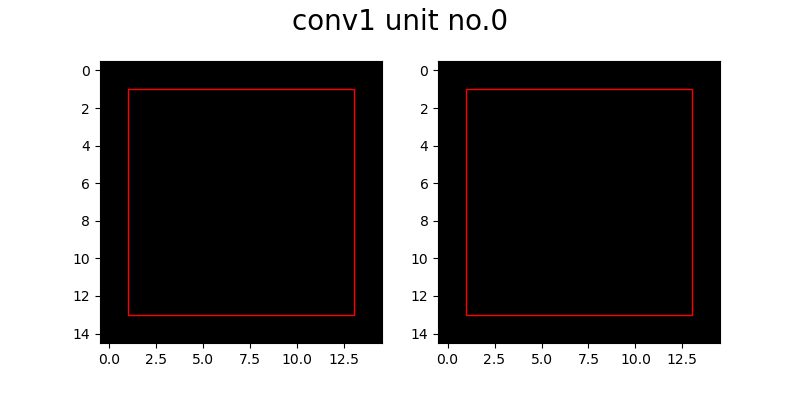

In [11]:
# Get the xn just big enough.
xn_list = xn_to_center_rf(model)

# Calculate RF sizes of all conv layers
rf_size_object = RfSize(model, 227)
layer_indices, max_rfs = rf_size_object.calculate()

# Define layer-specific info
layer_name = f"conv{conv_i + 1}"
xn = xn_list[conv_i]
layer_idx = layer_indices[conv_i]
max_rf = max_rfs[conv_i]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
fig.suptitle(f"{layer_name} unit no.{unit_i}", fontsize=20)
ax1.clear()
ax2.clear()
im1 = ax1.imshow(np.zeros((xn, xn, 3)), vmin=-1, vmax=1)
im2 = ax2.imshow(np.zeros((xn, xn, 3)), vmin=0, vmax=1)

def bar_generator(splist, model, layer_idx, unit_i):
    """
    Bar generator.
    
    Note for user - create an instance of this generator and pass it as the
                    'frame' keyword argument of animation.FuncAnimation().
    
    Parameters
    ----------
    splist     - bar stimulus parameter list.\n
    model      - neural network.\n
    layer_idx  - index of the layer of interest.\n
    unit_i     - index of the unit of interest.
    
    Yields
    ------
    center_response - center repsonse of the unit to bar_i (float).\n
    new_bar  - bar image in (3, yn, xn) format (numpy.ndarray).\n
    bar_sum  - weighted sum of bars in (3, yn, xn) format (numpy.ndarray).\n
    bar_i    - the index of the bar stimuli (int).\n
    num_bars - the total number of bars (int).
    """
    num_bars = len(splist)
    xn = splist[0]['xn']
    yn = splist[0]['yn']
    bar_sum = np.zeros((3, yn, xn))

    for bar_i, params in enumerate(splist):
        new_bar = stimfr_bar_color(params['xn'], params['yn'],
                                    params['x0'], params['y0'],
                                    params['theta'], params['len'], params['wid'], 
                                    params['aa'], *params['fgval'], *params['bgval'])
        new_bar_tensor = torch.tensor(np.expand_dims(new_bar, axis=0)).type('torch.FloatTensor')
        # Present the patch of bars to the truncated model.
        y, _ = truncated_model(new_bar_tensor, model, layer_idx)
        yc, xc = calculate_center(y.shape[-2:])
        center_response = y[0, unit_i, yc, xc].detach().numpy()
        bar_sum += max(center_response, 0) * new_bar
        yield center_response, new_bar, bar_sum, bar_i, num_bars

def animate_func(frame):
    """
    Animation function used to update the bar mapping images.
    
    Note for user - pass the function name as the second argument of
                    animation.FuncAnimation().
    
    Parameters
    ----------
    frame[0] - center repsonse of the unit to bar_i (float).\n
    frame[1] - new bar image in (3, yn, xn) format (numpy.ndarray).\n
    frame[2] - weighted sum of bars in (3, yn, xn) format (numpy.ndarray).\n
    frame[3] - the index of the bar stimuli (int).\n
    frame[4] - the total number of bars (int).
    """
    im1.set_data((np.transpose(frame[1], (1,2,0))+1)/2)
    ax1.set_title(f"response = {frame[0]:.2f}")

    vmin = frame[2].min()
    vmax = frame[2].max()
    # im2.set_clim(vmin=vmin, vmax=vmax)
    vrange = vmax - vmin
    if math.isclose(vrange, 0):  # prevent zero-division
        vrange = 1
    im2.set_data(((np.transpose(frame[2], (1,2,0)))-vmin)/(vrange))
    ax2.set_title(f"bar no. {frame[3]}/{frame[4]}")

# Create stimulus set
splist = stimset_dict(xn,max_rf,blen_rf_ratios,aspect_ratios,orientations,fgvals,bgvals)

# Create stimulus generator
bar_gen = bar_generator(splist, model, layer_idx, unit_i)

"""
The animation will be active as long as the variable 'ani' lives. Therefore,
it is important to have the notebook magic: %matplotlib ipympl.
!pip install ipympl
%matplotlib ipympl

Also, the animation function is difficult to debug because it sliences error
messages.

For details, see https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation
"""
ani = animation.FuncAnimation(fig, animate_func, frames=bar_gen,
                              interval=animation_interval_ms, save_count=0,
                              cache_frame_data=False, repeat=False)

padding = (xn - max_rf)//2
rect1 = make_box((padding-1, padding-1, padding+max_rf-1, padding+max_rf-1))
ax1.add_patch(rect1)
rect2 = make_box((padding-1, padding-1, padding+max_rf-1, padding+max_rf-1))
ax2.add_patch(rect2)

plt.show()